# SOD 314 - Numerical project in Python - Cooperative Kernel Regression
*Author : Lucas Selini*

# Part I (Class 1 and 2)

In [68]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import random
import networkx as nx
from tqdm import tqdm
from tqdm.notebook import trange

Load the data :

In [69]:
with open('./database/first_database.pkl', 'rb') as f:
    x, y = pickle.load(f)

In [70]:
# Define the euclidian kernel function
def k(x, xi):
    return np.exp(-np.linalg.norm(x - xi)**2)

# Define the matrix K = (k(x,y))
def compute_K(X,Y):
    return np.array([[k(Xi,Yj) for Yj in Y] for Xi in X])

# Define the evaluation of the function f defined by alpha at points x
def plot_f(alpha,x_selected,x):
    K = compute_K(x,x_selected)
    return K@alpha

Parameters :

In [71]:
# Number of data points
n, m, a = 100, 10, 5
sigma = 0.5
nu = 1

Text(0, 0.5, 'y')

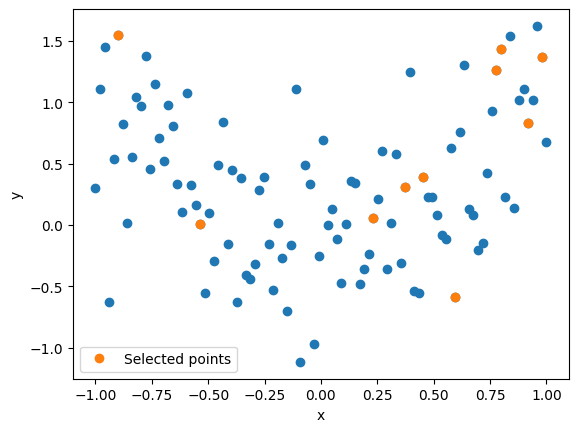

In [72]:
# Select m random data points
sel = [i for i in range(n)]
ind = np.random.choice(sel, m, replace=False)
x_selected = [x[i] for i in ind] #x_train 
y_selected = [y[i] for i in ind] #y_train

y_n = y[:n]
x_n = x[:n]

plt.plot(x_n,y_n,'o')
plt.plot(x_selected,y_selected,'o',label="Selected points")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

Agents split :

In [73]:
agents = np.array_split(np.random.choice(np.array(range(n)),size=n, replace=False),a)
W = np.ones((a,a))/a

Find the true $\alpha^\star$ using linear algebra (Ridge euclidian kernel regression, centralized fashion)

In [85]:
K_mm = compute_K(x_selected,x_selected)
K_nm = compute_K(x_n,x_selected)

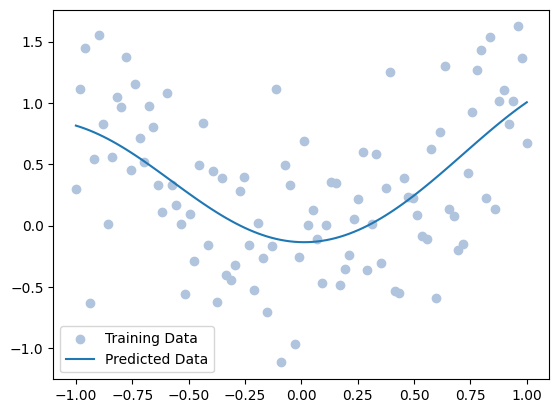

In [86]:
# Ridge euclidian kernel regression (centralized fashion)
alpha_star = np.linalg.solve((sigma**2)*K_mm + K_nm.T@K_nm,K_nm.T@y[:n])
#print('alpha_star =', alpha_star)

y_pred_star = np.dot(K_nm, alpha_star)

# Plot the results
plt.scatter(x_n,y_n,label='Training Data',color='lightsteelblue')
plt.plot(x_n,y_pred_star,label='Predicted Data')
plt.legend()
plt.show()


In [88]:
s = 250
x_prime = np.linspace(-1,1,s)
f_approx_true_linalg = plot_f(alpha_star,x_selected,x_prime)

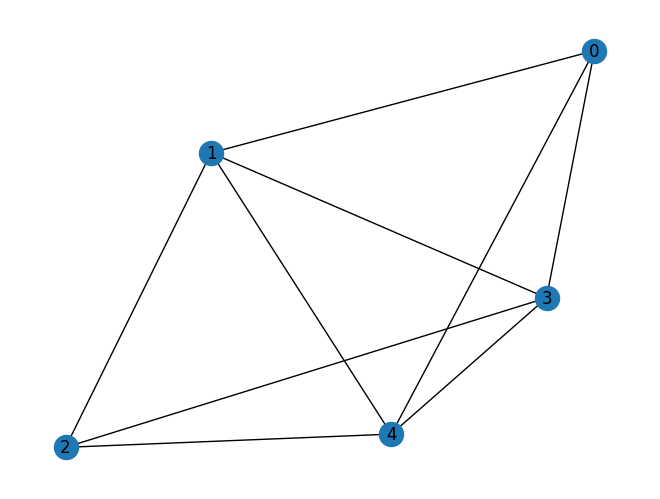

In [76]:
# Create a communication graph
G = nx.Graph()

# Add nodes representing the 5 agents
G.add_nodes_from(range(a))

# Add circular edges
for i in range(a):
    G.add_edge(i, (i+1) % a)

# Add some other edges
# G.add_edge(0, 2)
G.add_edge(1, 3)
G.add_edge(2, 4)
G.add_edge(3, 0)
G.add_edge(4, 1)

#Visualize the communication graph
nx.draw(G, with_labels=True)
plt.show()

## Study of the $g_a$

The problem we want to solve in this part is 
$$\alpha^\star = \arg\min_{\alpha \in \mathbb{R}^m} \sum_{a=1}^5 \frac{1}{5}\frac{1}{2}\alpha^T K_{mm}\alpha + \frac{1}{2\sigma^2}\sum_{i\in A}\|y_i - K_{(i)m}\alpha\|^2_2$$

Let us then define, for $a \in \{1,...,5\}$,
$$g_a \colon \alpha \mapsto \frac{1}{5}\frac{1}{2}\alpha^T K_{mm}\alpha + \frac{1}{2\sigma^2}\sum_{i\in A}\|y_i - K_{(i)m}\alpha\|^2_2$$
Therefore, the problem is now : $\alpha^\star = \arg\min_{\alpha \in \mathbb{R}^m} \sum_{a=1}^5 g_a(\alpha)$. To correctly choose the parameters for the Decentralized Gradient Descent (DGD) algorithm, we need to study the smoothness of the $g_a$. 

- First of all, the $g_a$ are convex functions as the sum of convex functions.
- We need to find $L_a$ such that $g_a$ is $L_a$-smooth. For this, let us look at the Hessian matrix $\nabla^2 g_a(\alpha)$ of $g_a$ : 
$$\nabla^2 g_a(\alpha) = \frac{1}{5}K_{mm} + \frac{1}{\sigma^2}\sum_{i\in A} K_{(i)m}K_{(i)m}^T$$
We want $L_a$ to be such that $0 \preccurlyeq \nabla^2 g_a(\alpha) \preccurlyeq L_a I_m$. To find $L_a$ we are going to look at the eigenvalues of $\nabla^2 g_a(\alpha)$. We need to choose $L_a$ such that all eigenvalues of $\nabla^2 g_a(\alpha)$ are smaller than $L_a$.
Then, we choose $L = \max_{a} L_a$. 

In [77]:
m_a = np.zeros(a)
L_a = np.zeros(a)
K = compute_K(x_n, x_n)
K_mm = K[ind, :][:, ind]

for j in range(a):
    nabla_g_a = K_mm / 5
    for i in agents[j]:
        K_im = K[i, :][ind]
        nabla_g_a += K_im @ K_im.T / (sigma ** 2)
    
    eigenval, eigenvec = np.linalg.eig(nabla_g_a)
    L_a[j] = np.max(np.abs(eigenval))
    m_a[j] = np.min(np.abs(eigenval))

L = np.max(L_a)
m = np.min(m_a)

print("L =", L)
print("m =", m)

L = 4082.158473755611
m = 3.3646334984339547e-15


## Decentralized Gradient Descent

In [78]:
def g(alpha,K,ind,Y,n,sigma):
    K_mm = K[ind,:][:,ind]
    K_nm = K[:n][:,ind]
    return alpha.T@K_mm@alpha/2 +  np.linalg.norm(Y[:n] - K_nm@alpha,ord=2)**2/(2*sigma**2)

In [79]:
def nabla_g_a(alpha,a,sigma,y,K,ind,agents):
    K_mm = K[ind,:][:,ind]
    
    somme = np.zeros(len(alpha))
    for i in agents[a]:
        K_im = K[i,:][ind]
        somme += (y[i] - K_im@alpha)*K_im.T
        
    return K_mm@alpha/5  - somme/(sigma**2)

In [80]:
def DGD(nb_it,agents,ind,W,K,Y,step_size,sigma,alpha_star):
    
    nb_agents = len(agents) # Number of agents at play
    m = len(ind)
    error = np.zeros((nb_it,nb_agents))

    # We start by initializing the alpha at each devices : alpha_O^i = 0
    y = np.zeros((nb_agents,m))
    g_val = np.zeros(nb_it)
    for k in tqdm(range(nb_it)):
        # We update y
        new_y = y.copy()
        
        # Mixing
        mixing = W@y
        
        # Update 
        for a in range(nb_agents):
            grad = nabla_g_a(y[a],a,sigma,Y,K,ind,agents)
            new_y[a] = mixing[a] - step_size*grad
    
        y = new_y.copy()
        error[k] = np.linalg.norm(y - alpha_star,axis=1)
        g_val[k] = g(np.mean(y,axis=0),K,ind,Y,n,sigma)
        
    return y, error, g_val


In [87]:
nb_it = 50000
K = compute_K(x[:n],x[:n])
step_size = 1/L
res,error,g_val = DGD(nb_it,agents,ind,W,K,y_n,step_size,sigma,alpha_star)

100%|██████████| 50000/50000 [01:35<00:00, 521.83it/s]


In [90]:
alpha_DGD = np.mean(res,axis=0)

Text(0.5, 1.0, 'Plot of the optimality gap $\\|\\|\\alpha_t^i - \\alpha^*\\|\\|$ \n as a function of the number of iteration t')

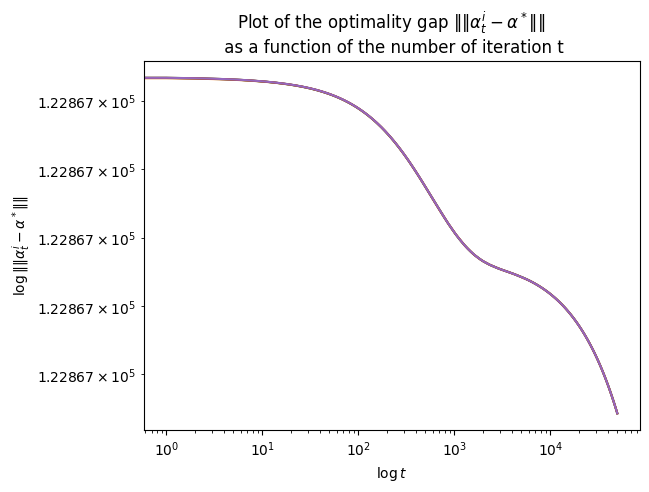

In [91]:
plt.loglog(error)
plt.xlabel("$\\log t$")
plt.ylabel("$\\log \\|\\|\\alpha_t^i - \\alpha^*\\|\\|$")
plt.title("Plot of the optimality gap $\\|\\|\\alpha_t^i - \\alpha^*\\|\\|$ \n as a function of the number of iteration t")

Text(0.5, 1.0, 'Plot of $f$ \n Error between both = 0.2792581326930793')

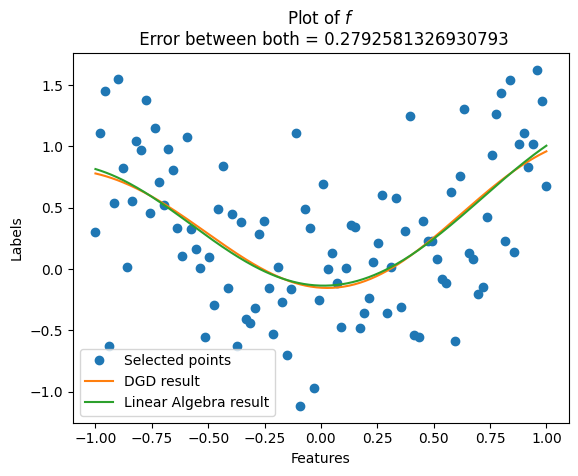

In [93]:
f_approx = plot_f(alpha_DGD,x_selected,x_prime)
plt.plot(x[:n],y[:n],'o',label="Selected points")
plt.plot(x_prime,f_approx,label="DGD result")
plt.plot(x_prime,f_approx_true_linalg,label="Linear Algebra result")
plt.legend()
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Plot of $f$ \n Error between both = " +str(np.linalg.norm(f_approx-f_approx_true_linalg)))